<a href="https://colab.research.google.com/github/joselopez11c/mi-primer-proyecto/blob/main/remates.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [81]:
!pip install pdfplumber
!pip install curlify

import requests
import re
import pandas as pd
from bs4 import BeautifulSoup
from google.colab import drive
import os
import pdfplumber
import tempfile
import curlify

In [ ]:
url = 'https://remaju.pj.gob.pe/remaju/pages/publico/remateExterno.xhtml'

headers = {
    'Accept': 'application/xml, text/xml, */*; q=0.01',
    'Accept-Language': 'en-US,en;q=0.9,es;q=0.8',
    'Connection': 'keep-alive',
    'Content-Type': 'application/x-www-form-urlencoded; charset=UTF-8',
    'DNT': '1',
    'Faces-Request': 'partial/ajax',
    'Origin': 'https://remaju.pj.gob.pe',
    'Referer': 'https://remaju.pj.gob.pe/remaju/pages/publico/remateExterno.xhtml',
    'Sec-Fetch-Dest': 'empty',
    'Sec-Fetch-Mode': 'cors',
    'Sec-Fetch-Site': 'same-origin',
    'User-Agent': 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_7) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/124.0.0.0 Safari/537.36',
    'X-Requested-With': 'XMLHttpRequest',
}

# Realizar la solicitud GET
response = requests.get(url, headers=headers)
cookie_header = 'JSESSIONID=' + response.cookies.get_dict().get('JSESSIONID')


def fetch_page(first_row):
  dataPagination = {
      'javax.faces.partial.ajax': 'true',
      'javax.faces.source': 'formBuscarRemateExterno:listaRemate',
      'javax.faces.partial.execute': 'formBuscarRemateExterno:listaRemate',
      'javax.faces.partial.render': 'formBuscarRemateExterno:listaRemate',
      'javax.faces.behavior.event': 'page',
      'javax.faces.partial.event': 'page',
      'formBuscarRemateExterno:listaRemate_pagination': 'true',
      'formBuscarRemateExterno:listaRemate_skipChildren': 'true',
      'formBuscarRemateExterno:listaRemate_first': str(first_row),
      'formBuscarRemateExterno:listaRemate_rows': '12',
      'formBuscarRemateExterno': 'formBuscarRemateExterno',
  }
  response = requests.post(url, headers=headers, data=dataPagination)
  return response

def downloadFile(idFile, viewState, file_path):
  headersDownload = {
      'Accept': 'application/xml, text/xml, */*; q=0.01',
      'Accept-Language': 'en-US,en;q=0.9,es;q=0.8',
      'Connection': 'keep-alive',
      'Content-Type': 'application/x-www-form-urlencoded; charset=UTF-8',
      'DNT': '1',
      'Faces-Request': 'partial/ajax',
      'Origin': 'https://remaju.pj.gob.pe',
      'Referer': 'https://remaju.pj.gob.pe/remaju/pages/publico/remateExterno.xhtml',
      'Sec-Fetch-Dest': 'empty',
      'Sec-Fetch-Mode': 'cors',
      'Sec-Fetch-Site': 'same-origin',
      'User-Agent': 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_7) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/124.0.0.0 Safari/537.36',
      'X-Requested-With': 'XMLHttpRequest',
  }
  dataFile = {
      'formBuscarRemateExterno': 'formBuscarRemateExterno',
      str(idFile): '',
      'javax.faces.ViewState': viewState
  }

  #payload = 'formBuscarRemateExterno=formBuscarRemateExterno&'+str(idFile)+'=&javax.faces.ViewState='+viewState

  headersDownload['Cookie'] = cookie_header
  response = requests.post(url, headers=headersDownload, data=dataFile)
  print(headersDownload)
  print(dataFile)
  if response.status_code == 200:
    with open(file_path, 'wb') as file:
        file.write(response.content)
        print(f"Archivo guardado en {file_path}")
  else:
      print(f"Error descargando el archivo en {file_path}")


page = fetch_page(0) ####################################################### LLAMADA A LA PAGINA


In [ ]:

soup = BeautifulSoup(page.content, 'xml')

update_tag = soup.find('update', {'id': 'j_id1:javax.faces.ViewState:0'})
view_state_value = update_tag.text

cdata_content = soup.find('update').text

# Ahora parseamos el contenido del CDATA, que es HTML
soup_html = BeautifulSoup(cdata_content, 'html.parser')

# Buscar todos los div con la clase 'card azul'
cards = soup_html.find_all('div', class_='card azul')

data = []
for card in cards:
    # Obtener número de remate y convocatoria
    remate_info = card.find('span', class_='text-bold label-danger h6').get_text(strip=True) if card.find('span', class_='text-bold label-danger h6') else 'No disponible'

    # Dividir la información de remate en número y convocatoria
    if remate_info != 'No disponible':
        parts = remate_info.split(" - ")
        remate_number = parts[0] if len(parts) > 0 else 'No disponible'
        convocatoria = parts[1] if len(parts) > 1 else 'No disponible'
    else:
        remate_number = 'No disponible'
        convocatoria = 'No disponible'

    # Ubicación, buscando la etiqueta específica y extrayendo el texto siguiente
    location_tag = card.find('i', class_='fa fa-map-marker')
    location = location_tag.find_next_sibling(text=True).strip() if location_tag else 'No disponible'

    # Descripción del inmueble, buscando el contenedor específico
    description = card.find('div', class_='texto-info-scroll').get_text(strip=True) if card.find('div', class_='texto-info-scroll') else 'No disponible'

    # Buscar todos los scripts dentro del card
    scripts = card.find_all('script')
    script_id = scripts[-1].get('id')[:-2] if scripts and scripts[-1].get('id').endswith('_s') else 'Script ID no encontrado'

    # Guardar los datos extraídos en la lista
    data.append({
        'Numer': remate_number,
        'Convocation': convocatoria,
        'Location': location,
        'Description': description,
        'Script ID': script_id
    })

# Crear un DataFrame con los datos recolectados
df = pd.DataFrame(data)

df


<ipython-input-74-bcd4370d7c00>:30: DeprecationWarning: The 'text' argument to find()-type methods is deprecated. Use 'string' instead.
  location = location_tag.find_next_sibling(text=True).strip() if location_tag else 'No disponible'


,Numer,Convocation,Location,Description,Script ID
0,Remate N° 14060,PRIMERA CONVOCATORIA,VICE,LOTE 6 MANZANA 58 DEL ASENTAMIENTO HUMANO LA T...,formBuscarRemateExterno:listaRemate:0:j_idt171
1,Remate N° 14059,PRIMERA CONVOCATORIA,URACA,BIEN INMUEBLE UBICADO EN EL ASENTAMIENTO HUMAN...,formBuscarRemateExterno:listaRemate:1:j_idt171
2,Remate N° 14058,PRIMERA CONVOCATORIA,MIRAFLORES,"SE UBICA EN AVENIDA, PRÓXIMO A LAS AV. TOMÁS M...",formBuscarRemateExterno:listaRemate:2:j_idt171
3,Remate N° 14057,PRIMERA CONVOCATORIA,BARRANCA,INMUEBLE UBICADO EN CALLE CASTILLA N° 368 ACTU...,formBuscarRemateExterno:listaRemate:3:j_idt171
4,Remate N° 14056,PRIMERA CONVOCATORIA,MIRAFLORES,COCHERA NRO 44 UBICADO EN EL SÓTANO TRES CON U...,formBuscarRemateExterno:listaRemate:4:j_idt171
5,Remate N° 14055,PRIMERA CONVOCATORIA,MIRAFLORES,COCHERA NRO 43 UBICADO EN EL SÓTANO TRES CON U...,formBuscarRemateExterno:listaRemate:5:j_idt171
6,Remate N° 14054,PRIMERA CONVOCATORIA,CORONEL GREGORIO ALBARRACIN LANCHIPA,INMUEBLE UBICADO EN LA HABILITACIÓN URBANA PRO...,formBuscarRemateExterno:listaRemate:6:j_idt171
7,Remate N° 14053,PRIMERA CONVOCATORIA,NUEVO CHIMBOTE,BIEN INMUEBLE UBICADO EN CALLE 5 MZ. D LOTE 7-...,formBuscarRemateExterno:listaRemate:7:j_idt171
8,Remate N° 14052,PRIMERA CONVOCATORIA,SANTIAGO DE SURCO,EL INMUEBLE SE ENCUENTRA UBICADO EN UNIDAD INM...,formBuscarRemateExterno:listaRemate:8:j_idt171
9,Remate N° 14051,PRIMERA CONVOCATORIA,SANTIAGO DE SURCO,EL INMUEBLE SE ENCUENTRA UBICADO EN UNIDAD INM...,formBuscarRemateExterno:listaRemate:9:j_idt171


In [ ]:
# Iterar sobre las filas del DataFrame
for index, row in df.iterrows():
    print(f"Descargando archivo para fila {index}...")
    file_path = downloadFile(row['Script ID'], view_state_value)
    print(file_path)

    if file_path:
        try:
            # Leer el texto del archivo descargado con pdfplumber
            with pdfplumber.open(file_path) as pdf:
                text = ""
                for page in pdf.pages:
                    text += page.extract_text()

            # Imprimir el texto extraído
            print(f"Texto extraído para fila {index}:")
            print(text)
        except pdfplumber.PDFSyntaxError as e:
            print(f"Error al abrir el archivo PDF: {e}")
            print("Contenido de la respuesta:")
            print(open(file_path, "r").read())
    else:
        print(f"No se pudo descargar el archivo para fila {index}.")


In [ ]:
drive.mount('/content/drive')
# Ruta de la carpeta dentro de Google Drive
folder_path = '/content/drive/My Drive/Remates'
os.makedirs(folder_path, exist_ok=True)  # Crea la carpeta si no existe
print(cookie_header)

for index, row in df.iterrows():
  file_name = f"file_{index}.pdf"  # Asume que los archivos son PDFs
  file_path = os.path.join(folder_path, file_name)
  #print(row['Script ID'] + " " + view_state_value)
  downloadFile(row['Script ID'], view_state_value, file_path)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
JSESSIONID="E09Hw-cUHvkM8UtXMbsRzL73Ot1WHtz5AkQZxJRA.P-Nodo5:SRemaju7-3"
{'Accept': 'application/xml, text/xml, */*; q=0.01', 'Accept-Language': 'en-US,en;q=0.9,es;q=0.8', 'Connection': 'keep-alive', 'Content-Type': 'application/x-www-form-urlencoded; charset=UTF-8', 'DNT': '1', 'Faces-Request': 'partial/ajax', 'Origin': 'https://remaju.pj.gob.pe', 'Referer': 'https://remaju.pj.gob.pe/remaju/pages/publico/remateExterno.xhtml', 'Sec-Fetch-Dest': 'empty', 'Sec-Fetch-Mode': 'cors', 'Sec-Fetch-Site': 'same-origin', 'User-Agent': 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_7) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/124.0.0.0 Safari/537.36', 'X-Requested-With': 'XMLHttpRequest', 'Cookie': 'JSESSIONID="E09Hw-cUHvkM8UtXMbsRzL73Ot1WHtz5AkQZxJRA.P-Nodo5:SRemaju7-3"'}
{'formBuscarRemateExterno': 'formBuscarRemateExterno', 'formBuscarRemateExterno:listaRemate:0:j

In [ ]:
#PARA LEER EL ARCHIVO PDF Y PASARLO A TEXT

from google.colab import files

# Cargar archivo PDF desde tu sistema local
uploaded = files.upload()

# Obtener el nombre del archivo cargado
file_name = list(uploaded.keys())[0]

# Leer el texto del PDF con pdfplumber
with pdfplumber.open(file_name) as pdf:
    text = ""
    for page in pdf.pages:
        text += page.extract_text()

# Imprimir el texto extraído
print(text)

<?xml version="1.0" encoding="UTF-8" ?>
<!DOCTYPE html>
<html xmlns="http://www.w3.org/1999/xhtml"><head id="j_idt2">
			<meta http-equiv="X-UA-Compatible" content="IE=edge" />
            <meta http-equiv="Content-Type" content="text/html; charset=UTF-8" />
            <meta name="viewport" content="width=device-width, initial-scale=1.0, maximum-scale=1.0, user-scalable=0" />
            <meta name="apple-mobile-web-app-capable" content="yes" />
            <title>REMAJU - Remate Electrónico Judicial</title><link type="text/css" rel="stylesheet" href="/remaju/javax.faces.resource/theme.css.xhtml?ln=primefaces-pj" /><link type="text/css" rel="stylesheet" href="/remaju/javax.faces.resource/fa/font-awesome.css.xhtml?ln=primefaces&amp;v=8.0" /><link type="text/css" rel="stylesheet" href="/remaju/javax.faces.resource/components.css.xhtml?ln=primefaces&amp;v=8.0" /><link type="text/css" rel="stylesheet" href="/remaju/javax.faces.resource/inputnumber/inputnumber.css.xhtml?ln=primefaces&amp;v
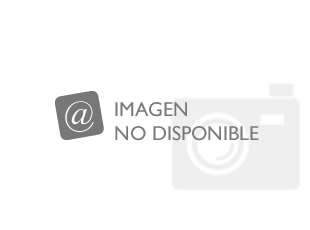
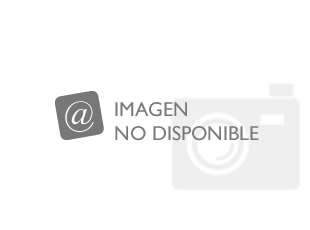
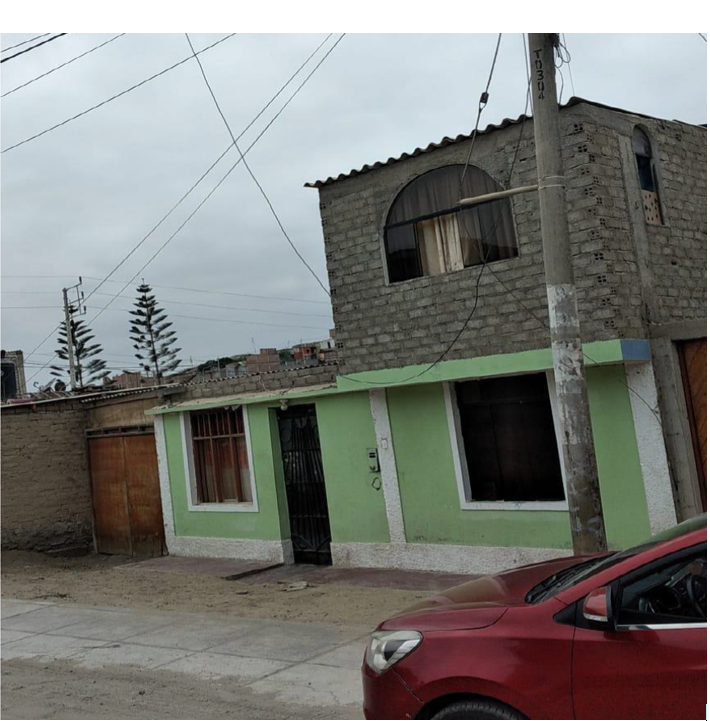
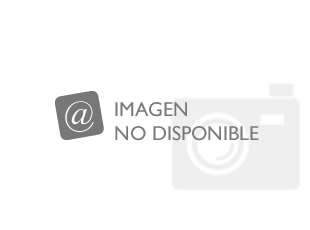

In [ ]:
import requests

url = "https://remaju.pj.gob.pe/remaju/pages/publico/remateExterno.xhtml"

headers = {
    'Accept': 'text/html,application/xhtml+xml,application/xml;q=0.9,image/avif,image/webp,image/apng,*/*;q=0.8,application/signed-exchange;v=b3;q=0.7',
    'Accept-Language': 'en-US,en;q=0.9,es;q=0.8',
    'Cache-Control': 'max-age=0',
    'Connection': 'keep-alive',
    'Content-Type': 'application/x-www-form-urlencoded',
    'Cookie': 'primefaces.download=true; JSESSIONID="dV55qt4kYXcLywJTTRhpjImoE1ETdAte9tlKBrzm.P-Nodo5:SRemaju7-3"; __uzma=1e1f2b47-3c69-4d88-856c-80a52b86aa2f; __uzmb=1715361188; __uzme=3007; _gid=GA1.3.906069933.1715361201; _ga_235TL8GKXM=GS1.1.1715366235.2.1.1715368139.0.0.0; _ga=GA1.1.1613688817.1715361201; __uzmc=8703710055810; __uzmd=1715368541'
    'DNT': '1',
    'Origin': 'https://remaju.pj.gob.pe',
    'Referer': 'https://remaju.pj.gob.pe/remaju/pages/publico/remateExterno.xhtml',
    'Sec-Fetch-Dest': 'document',
    'Sec-Fetch-Mode': 'navigate',
    'Sec-Fetch-Site': 'same-origin',
    'Sec-Fetch-User': '?1',
    'Upgrade-Insecure-Requests': '1',
    'User-Agent': 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_7) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/124.0.0.0 Safari/537.36',
    'sec-ch-ua': '"Chromium";v="124", "Google Chrome";v="124", "Not-A.Brand";v="99"',
    'sec-ch-ua-mobile': '?0',
    'sec-ch-ua-platform': '"macOS"',
}

data = {
    'formBuscarRemateExterno': 'formBuscarRemateExterno',
    'formBuscarRemateExterno:j_idt76:filtroRemate': '',
    'formBuscarRemateExterno:j_idt76:filtroNroExpediente': '',
    'formBuscarRemateExterno:j_idt76:precioBaseDesde_input': '',
    'formBuscarRemateExterno:j_idt76:precioBaseDesde_hinput': '',
    'formBuscarRemateExterno:j_idt76:precioBaseHasta_input': '',
    'formBuscarRemateExterno:j_idt76:precioBaseHasta_hinput': '',
    'formBuscarRemateExterno:j_idt76:filtroTipoInmueble_focus': '',
    'formBuscarRemateExterno:j_idt76:filtroTipoInmueble_input': '',
    'formBuscarRemateExterno:j_idt76:filtroDepartamento_focus': '',
    'formBuscarRemateExterno:j_idt76:filtroDepartamento_input': '',
    'formBuscarRemateExterno:j_idt76:filtroProvincia_focus': '',
    'formBuscarRemateExterno:j_idt76:filtroProvincia_input': '',
    'formBuscarRemateExterno:j_idt76:filtroDistrito_focus': '',
    'formBuscarRemateExterno:j_idt76:filtroDistrito_input': '',
    'formBuscarRemateExterno:j_idt76:filtroFases_focus': '',
    'formBuscarRemateExterno:j_idt76:filtroFases_input': '1',
    'formBuscarRemateExterno:j_idt76_active': '0',
    'formBuscarRemateExterno:captcha': '',
    'formBuscarRemateExterno:listaRemate:1:j_idt171': '',
    'formBuscarRemateExterno:listaRemate_rppDD': '4',
    'javax.faces.ViewState': '-4252674045340494179:8500983673274097523'
}

response = requests.post(url, headers=headers, data=data)
print(response.text)

# Check if the response contains content
if response.ok and 'application/pdf' in response.headers.get('Content-Type', ''):
    # Saving the PDF to a local file
    pdf_path = 'downloaded_file.pdf'
    with open(pdf_path, 'wb') as f:
        f.write(response.content)

    # Reading the PDF using pdfplumber
    with pdfplumber.open(pdf_path) as pdf:
        text = ""
        for page in pdf.pages:
            text += page.extract_text() or ''  # Append extracted text, use '' if None is returned

    # Print the extracted text
    print(text)

    # Optionally, remove the PDF file if not needed
    os.remove(pdf_path)

else:
    print("Failed to download a valid PDF file.")